In [1]:
import pandas as pd

from fastai.tabular.all import *

In [2]:
DATA_PATH = '../data/preprocessed_training_data.pkl'

In [3]:
df = pd.read_pickle(DATA_PATH)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3738937 entries, 0 to 3738936
Data columns (total 18 columns):
 #   Column              Dtype         
---  ------              -----         
 0   id                  object        
 1   timestamp           datetime64[ns]
 2   campaignId          object        
 3   platform            object        
 4   softwareVersion     object        
 5   sourceGameId        object        
 6   country             object        
 7   startCount          int64         
 8   viewCount           int64         
 9   clickCount          int64         
 10  installCount        int64         
 11  lastStart           datetime64[ns]
 12  startCount1d        int64         
 13  startCount7d        int64         
 14  connectionType      object        
 15  deviceType          object        
 16  install             int64         
 17  timeSinceLastStart  float64       
dtypes: datetime64[ns](2), float64(1), int64(7), object(8)
memory usage: 513.5+ MB


In [6]:
class_count_df = df.groupby('install').count()
class_count_df

n_0, n_1 = class_count_df.iloc[0, 0], class_count_df.iloc[1, 0]

w_0 = (n_0 + n_1) / (2.0 * n_0)
w_1 = (n_0 + n_1) / (2.0 * n_1)

w_0, w_1

(0.5060559911190347, 41.78143438226354)

In [8]:
df['install'] = df['install'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3738937 entries, 0 to 3738936
Data columns (total 18 columns):
 #   Column              Dtype         
---  ------              -----         
 0   id                  object        
 1   timestamp           datetime64[ns]
 2   campaignId          object        
 3   platform            object        
 4   softwareVersion     object        
 5   sourceGameId        object        
 6   country             object        
 7   startCount          int64         
 8   viewCount           int64         
 9   clickCount          int64         
 10  installCount        int64         
 11  lastStart           datetime64[ns]
 12  startCount1d        int64         
 13  startCount7d        int64         
 14  connectionType      object        
 15  deviceType          object        
 16  install             category      
 17  timeSinceLastStart  float64       
dtypes: category(1), datetime64[ns](2), float64(1), int64(6), object(8)
memory usage: 4

In [17]:
CAT_NAMES = ['campaignId', 'platform', 'softwareVersion',
             'sourceGameId', 'connectionType', 'deviceType', 'country']
CONT_NAMES = ['startCount', 'viewCount', 'clickCount', 
              'installCount', 'startCount1d', 'startCount7d', 
              'timeSinceLastStart']

dls = TabularDataLoaders.from_df(df, y_names='install', 
                                 cat_names=CAT_NAMES,
                                 cont_names=CONT_NAMES,
                                 procs=[Categorify, FillMissing, Normalize],
                                 splits=RandomSplitter(valid_pct=0.2)(range_of(df)),
                                 bs=1024)

In [18]:
dls.xs

,campaignId,platform,softwareVersion,sourceGameId,connectionType,deviceType,country,startCount,viewCount,clickCount,installCount,startCount1d,startCount7d,timeSinceLastStart
1422564,5986,1,85,9414,3,25692,206,0.899682,1.109663,-0.159340,-0.367338,-0.243125,1.205121,-0.305599
1221207,6412,1,105,22524,3,27933,162,1.737384,2.080751,2.964460,0.282590,0.105217,0.291202,-0.305182
2487525,7557,1,137,15348,3,10814,109,0.050959,-0.176712,-0.010588,0.932519,-0.330210,0.434002,-0.304138
510207,8807,1,101,6334,1,8440,39,-0.434026,-0.416331,-0.308092,-0.367338,-0.330210,-0.308557,-0.294744
936009,3571,1,141,19089,3,13316,195,0.359586,-0.340662,-0.159340,0.282590,-0.156039,0.119842,-0.299963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459548,4599,1,66,22455,1,7211,89,-0.246646,-0.151489,-0.159340,-0.367338,-0.504381,-0.194317,0.039263
3509209,970,2,40,111,1,23390,67,-0.522205,-0.454166,-0.308092,-0.367338,-0.504381,-0.537036,-0.305808
1066203,753,1,87,10176,3,9895,126,-0.489138,-0.428943,-0.308092,-0.367338,-0.243125,-0.451357,-0.305182
2529167,9569,1,137,7299,3,25634,206,-0.103355,-0.302828,-0.308092,-0.367338,-0.068954,-0.251437,-0.304973


In [19]:
dls.valid_ds

                               id           timestamp  campaignId  platform  \
1066973  5c4436c1d471af44f1597d70 2019-01-20 08:52:17         753         1   
2189744  5c42925b6b25e35c7c7f216b 2019-01-19 02:58:35        6876         1   
74841    5c347fe951c90503cbb7cc06 2019-01-08 10:48:09        1349         1   
715396   5c38c4150d72d3202f67fe32 2019-01-11 16:28:05        5547         2   
1311082  5c3549ec51c4126b1a05fbbf 2019-01-09 01:10:04        3236         1   
...                           ...                 ...         ...       ...   
537195   5c3c395abd7ef8e3e7a0819e 2019-01-14 07:25:14        7955         2   
3166680  5c40c94da8619c20d05b3a7b 2019-01-17 18:28:29        2142         1   
2394065  5c367ad326058f3d5922a05b 2019-01-09 22:50:59        3913         2   
280558   5c445f85bc2938596d82dd9b 2019-01-20 11:46:13        8754         2   
2772406  5c381c715e23967ec564078f 2019-01-11 04:32:49        1666         2   

         softwareVersion  sourceGameId  country  st

In [20]:
weights = [w_0, w_1]
class_weights=torch.FloatTensor(weights).cuda()
loss_func = CrossEntropyLossFlat(weights=class_weights)
roc_auc = RocAucBinary()

learn = tabular_learner(dls, layers=[500, 250], loss_func=loss_func, metrics=roc_auc)
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.0020892962347716093)

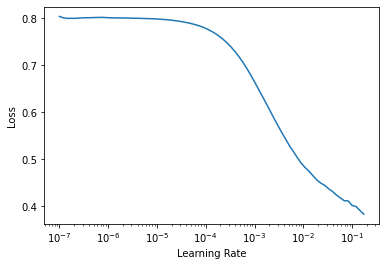

In [21]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(3, lr_min=0.017)

epoch,train_loss,valid_loss,roc_auc_score,time


In [14]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(9693, 273)
    (1): Embedding(3, 3)
    (2): Embedding(196, 31)
    (3): Embedding(222, 33)
    (4): Embedding(4, 3)
    (5): Embedding(28324, 498)
    (6): Embedding(1754, 105)
    (7): Embedding(34850, 559)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(1511, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=1511, out_features=500, bias=False)
      (2): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=500, out_features=250, bias=False)
      (2): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=250, out_features=2, bias=True)
    )
  )
)